# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pathlib

np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [2]:
# TODO: load your data
# df = pd.read_csv('path/to.csv', parse_dates=['Date'], index_col='Date')
DATA_PATH = pathlib.Path('../data/raw/api_aapl.csv')

df = pd.read_csv(DATA_PATH, parse_dates=['date'], index_col='date')

df = df.sort_index()

print("Dataset loaded successfully:")
df.head()

Dataset loaded successfully:


,open,high,low,close,volume
date,,,,,
1999-11-01,80.00,80.69,77.37,77.62,2487300
1999-11-02,78.00,81.69,77.31,80.25,3564600
1999-11-03,81.62,83.25,81.00,81.50,2932700
1999-11-04,82.06,85.37,80.62,83.62,3384700
1999-11-05,84.62,88.37,84.00,88.31,3721500


## Option B: Synthetic Generator (Use if you don't have data ready)

In [ ]:
# Synthetic series with regimes & jumps
# n=500
# dates=pd.bdate_range('2021-01-01', periods=n)
# mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
# sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
# eps = np.random.normal(mu, sigma)
# jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
# jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
# rets = eps + jumps
# price = 100*np.exp(np.cumsum(rets))
# df = pd.DataFrame({'price':price}, index=dates)
# df['ret'] = df['price'].pct_change().fillna(0.0)
# df['log_ret'] = np.log1p(df['ret'])
# df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Feature Engineering

In [3]:
PRICE_COLUMN = 'close'

df['ret'] = df[PRICE_COLUMN].pct_change().fillna(0.0)

In [4]:
# TODO: create at least two features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# Add your own:
df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,open,high,low,close,volume,ret,lag_1,roll_mean_5,roll_vol_20,y_next_ret,y_up
date,,,,,,,,,,,
1999-11-30,98.12,103.75,97.37,97.87,7528400,0.035004,-0.005260,0.004676,0.032609,0.053030,1
1999-12-01,101.00,104.50,100.06,103.06,5522900,0.053030,0.035004,0.015615,0.032958,0.069183,1
1999-12-02,103.12,110.62,101.75,110.19,5065700,0.069183,0.053030,0.021388,0.033887,0.043652,1
1999-12-03,112.19,115.56,111.87,115.00,5785000,0.043652,0.069183,0.031173,0.036136,0.008696,1
1999-12-06,114.56,117.31,111.44,116.00,4167700,0.008696,0.043652,0.039122,0.036610,0.015603,1


## Split

In [6]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5', 'roll_vol_20']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

In [7]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = np.sqrt(mean_squared_error(y_te_reg, pred))
print('RMSE:', rmse)

RMSE: 0.027852622309945976


              precision    recall  f1-score   support

           0       0.44      0.03      0.05       611
           1       0.53      0.97      0.68       683

    accuracy                           0.52      1294
   macro avg       0.48      0.50      0.37      1294
weighted avg       0.48      0.52      0.38      1294



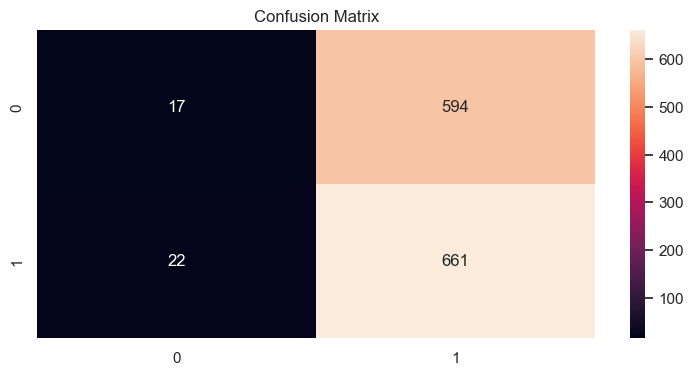

In [8]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

## Interpretation (Markdown)
- What worked?
- Where might assumptions fail?
- How would you extend features or model?

- **What worked?**
  - **Pipeline and Workflow Execution**: The entire technical workflow, from data loading and feature engineering to time-aware splitting and building/evaluating the Pipelines, was successful. The code ran without errors and provided a clear, quantifiable baseline for model performance.
  - **Feature Creation**: The `lag_1`, `roll_mean_5`, and `roll_vol_20` features were implemented correctly, and critically, data leakage was avoided by using the `.shift(1)` method. This is a crucial best practice in time-series modeling.

- **Where might assumptions fail? / What Fails?**
  - **Forecasting Model (Linear Regression)**:
    - This model performed very poorly. The RMSE of 0.02785 is substantial for daily returns, indicating that the model's predictions have a large average error and are not reliable.
    - The model's failure stems from its core assumption: that a stable **linear relationship** exists between past returns/volatility and the next day's return. Financial markets are highly dynamic and complex; this simple linear assumption is almost always invalid.
  
  - **Classification Model (Logistic Regression)**:
    - This model is a classic example of being "deceptively accurate." While the **overall accuracy is 52%**, which is slightly better than a 50/50 random guess, a deeper look reveals a critical flaw.
    - **A Biased Strategy**: The confusion matrix and classification report show that the model is heavily **biased towards predicting "Up" (class 1)**. Out of 1294 test samples, it predicted "Up" 1254 times.
    - **The Illusion of High Recall**: The model achieves a 97% recall for the "Up" class. This seems impressive, but it's only because the model almost always guesses "Up," so it naturally "recalls" most of the days the market actually went up.
    - **The Reality of Low Precision**: Its precision for the "Up" class is only 53%. This means that when the model predicts the market will go up, it's only correct 53% of the time—no better than a coin toss.
    - **Complete Failure to Predict "Down"**: Most critically, the recall for the "Down" class is a mere 3%. This means the model **fails to identify almost any day the market will go down**, making it extremely dangerous and useless in a real-world scenario.
    - **Root Cause**: The model did not learn any true predictive patterns. It simply learned the historical bias in the training data (i.e., there were likely slightly more up days than down days) and adopted the naive strategy of "always guess up" to achieve an accuracy just over 50%.

- **How would you extend features or model?**
  - Based on this analysis, the next steps must focus on building a model that learns real patterns, not just simple biases.
    1.  **Address Class Imbalance**: First, I would check the balance of "Up" vs. "Down" days in the training set. If it's imbalanced, I would use the `class_weight='balanced'` parameter in `LogisticRegression` to penalize misclassifications of the minority class (likely "Down") more heavily.
    2.  **More Advanced Feature Engineering**: The current features are too simplistic. I would create more financially meaningful indicators, such as:
        - **Momentum Indicators**: Relative Strength Index (RSI), MACD.
        - **Volatility Measures**: Average True Range (ATR).
        - **Cross-Market Correlations**: Lagged returns of other indices (like the S&P 500) or volatility indices (like the VIX).
    3.  **Use More Powerful Models**: Since linear models failed, I would move to non-linear models that can capture more complex patterns:
        - **Tree-Based Models**: Random Forest, XGBoost, or LightGBM are very powerful for classification tasks on tabular data.
        - **Ensemble Methods**: Combining the predictions of several different models can often lead to more robust results.

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.